# Model training notebook with wandb logging 

wandb description

In [73]:
description = "efficientnet pretrained True 20 epoch 1971 focal present, 1971 human labelled present and 3942 human labelled absent."

In [74]:
# !pip install wandb
# ! pip install wandb --upgrade

In [75]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [76]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [7]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, show_sample_from_df, clean_confidence_cats, get_recording_durations, plot_metrics_across_thresholds
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import glob
import sklearn
import ipywidgets as widgets

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"

# Log some hyperparameters

In [9]:
n_samples_per_class = 1700
one_output_neuron = True
random_seed = 42
learning_rate = 0.01
epochs=20
bandpass = False

In [10]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [11]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

focal_df = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "focal_osfls_thresh_0.98_ngen_2601.pkl")

train_df.confidence_cat.value_counts()


confidence_cat
0     41658
3      1437
2       494
5       331
1       319
4        77
6        50
33        1
Name: count, dtype: int64

In [12]:
focal_df[['target_presence']] = 1.0
focal_df = focal_df[["target_presence"]]
focal_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                   1.0
                                                   7.5        10.5                  1.0
                                                   13.5       16.5                  1.0
                                                   15.0       18.0                  1.0
                                                   24.0       27.0                  1.0

In [13]:
valid_df.value_counts()

target_absence  target_presence  confidence_cat
1.0             0.0              0                 9947
0.0             1.0              2                  360
                                 3                  357
                                 1                  296
                                 4                   28
                                 0                    2
Name: count, dtype: int64

In [14]:
train_df = clean_confidence_cats(train_df)
valid_df = clean_confidence_cats(valid_df)
train_df["target_absence"] = 1-train_df["target_presence"]
valid_df["target_absence"] = 1-valid_df["target_presence"]
train_df = train_df[["target_absence", "target_presence"]]
valid_df = valid_df[["target_absence", "target_presence"]]
train_df.value_counts(), valid_df.value_counts()

(target_absence  target_presence
 1.0             0.0                41770
 0.0             1.0                 1784
 Name: count, dtype: int64,
 target_absence  target_presence
 1.0             0.0                9947
 0.0             1.0                 387
 Name: count, dtype: int64)

# Remove invalid samples from invalid_samples.log

In [15]:
# read the contents of invalid_samples.log
with open("invalid_samples.log") as f:
    invalid_samples = f.readlines()
invalid_samples = [x.strip() for x in invalid_samples]
# convert to paths
invalid_samples = [Path(x) for x in invalid_samples]
# remove the invalid samples from the training set
train_df = train_df.drop(invalid_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_35165/1377274677.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df = train_df.drop(invalid_samples)


# Remove any additional invalid samples 
These may be printed during model training. 


In [16]:
def remove_files_from_df(df: pd.DataFrame, files: list):
    ''' 
    df must be a multi-indexed DataFrame with the first level being the file path.
    files is a list of string filepaths. 
    '''
    files = [Path(f) for f in files]
    df.drop(files, inplace=True)
    return df

In [17]:
short_samples = [("../../data/raw/recordings/OSFL/recording-293782.mp3"),
("../../data/raw/recordings/OSFL/recording-294264.mp3"),
("../../data/raw/recordings/OSFL/recording-292726.mp3"),
("../../data/raw/recordings/OSFL/recording-300271.mp3"),
("../../data/raw/recordings/OSFL/recording-296664.mp3"),]
train_df = remove_files_from_df(train_df, short_samples)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_35165/3185280771.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(files, inplace=True)


In [18]:
short_focal_samples = [("../../data/raw/recordings/OSFL/recording-538292.flac"),
("../../data/raw/recordings/OSFL/recording-255624.flac"),
("../../data/raw/recordings/OSFL/recording-255625.flac"),
("../../data/raw/recordings/OSFL/recording-168894.flac"),
("../../data/raw/recordings/OSFL/recording-104311.mp3"), 
("../../data/raw/recordings/OSFL/recording-100695.flac")]
focal_df.drop(short_focal_samples, inplace=True)


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_35165/740663884.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  focal_df.drop(short_focal_samples, inplace=True)


In [19]:
invalid_samples

[PosixPath('../../data/raw/recordings/OSFL/recording-104149.mp3')]

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [20]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
# assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
# assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

df6b00cc6ffa4efbaca189fa4093169c5ee439cbce5703f0454eed5da8081ed3 d54f471abbc0d72e038b376de5896e0efd679391e1d531dd1b1f2f259e813d3c


In [21]:
zero_len_recordings = [Path('../../data/raw/recordings/OSFL/recording-565606.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565607.flac'),
       Path('../../data/raw/recordings/OSFL/recording-565618.flac')],
      

drop_df = train_df.loc[zero_len_recordings]
train_df.drop(drop_df.index, inplace=True)

In [22]:
focal_df.target_presence.value_counts()

target_presence
1.0    1971
Name: count, dtype: int64

# Resample

In [23]:
## This is done explicitly taking n from each clip source. 

from opensoundscape.data_selection import resample

# # upsample (repeat samples) or downsample so that both classes have equal numbers of samples
# balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=380,random_state=random_seed)
# balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

In [24]:
focal_df

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 6.0        9.0                   1.0
                                                   7.5        10.5                  1.0
                                                   13.5       16.5                  1.0
                                                   15.0       18.0                  1.0
                                                   24.0       27.0                  1.0
...                                                                                 ...
../../data/raw/recordings/OSFL/recording-293120... 121.5      124.5                 1.0
                                                   124.5      127.5                 1.0
                                                   154.5      157.5                 1.0
                                                   156.0      159.0                 1.0
../../data/raw/recordings/OSFL/recording-556648... 37.5       40.5                  1.0

[1971 rows x 1 columns]

In [25]:
# Sample 1971 focal examples, 1971 human labelled present examples and 3942 human labelled absent examples for this experiment
absent = train_df[train_df.target_presence == 0]
present = train_df[train_df.target_presence == 1]

absent = absent.sample(3942, random_state=random_seed)
present = present.sample(1772, random_state=random_seed)

train_df = pd.concat([absent[['target_presence']], present[['target_presence']], focal_df[['target_presence']]])

train_df = train_df.sample(frac=1, random_state=random_seed)
train_df.value_counts()


target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [26]:
train_df.head()

target_presence
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-552477... 139.5      142.5                 0.0
../../data/raw/recordings/OSFL/recording-538633... 18.0       21.0                  1.0
../../data/raw/recordings/OSFL/recording-81135.... 523.5      526.5                 1.0
../../data/raw/recordings/OSFL/recording-291777... 253.5      256.5                 1.0
../../data/raw/recordings/OSFL/recording-293683... 10.5       13.5                  1.0

# Experiment with bandpassing of the input signal

In [27]:
training_raw_data = pd.read_pickle(data_path / "interim" / "cleaned_metadata.pkl")
osfls = training_raw_data[training_raw_data.species_code == "OSFL"]
# Show the minimum frequencies in khz for OSFL
osfls.loc[osfls['species_code'] == 'OSFL'].min_tag_freq.str.split('kHz').str[0].astype(float).describe()

count    5039.000000
mean        1.922008
std         0.403280
min         0.050000
25%         1.680000
50%         1.960000
75%         2.190000
max         3.130000
Name: min_tag_freq, dtype: float64

In [28]:
# Show the maximum frequencies in khz for OSFL
osfls.loc[osfls['species_code'] == 'OSFL'].max_tag_freq.str.split('kHz').str[0].astype(float).describe()

count    5039.000000
mean        4.404560
std         0.476502
min         2.470000
25%         4.110000
50%         4.340000
75%         4.620000
max        11.850000
Name: max_tag_freq, dtype: float64

In [29]:
max_freq = 5340
min_freq = 1100

Band pass frequencies of 1.1kHz and 5.34 khz are chosen to stay in 2 standard deviations of the mean of high and low frequency bounds. This matches what is observed in the spectrograms for the bird call. 

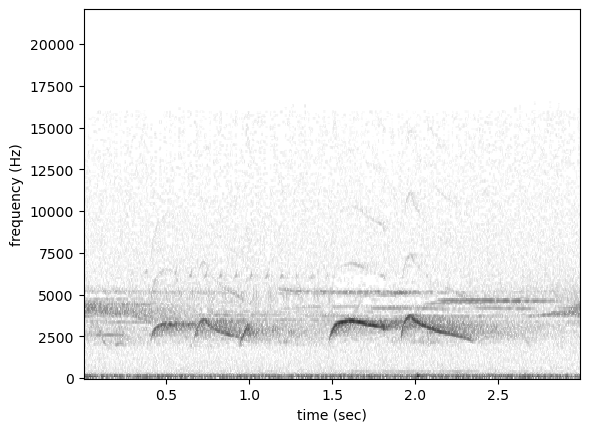

In [30]:
show_sample_from_df(train_df, 'present')

# Shuffle the training data

In [31]:
train_df = train_df.sample(frac=1)
balanced_valid_df = balanced_valid_df.sample(frac=1)

# Drop the redundant absence class

In [32]:
train_df = train_df[["target_presence"]]
balanced_valid_df = balanced_valid_df[["target_presence"]]
train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

# Calculate recording durations for each recording in the training data
Some recordings might be corrupt and have zero samples. 

In [33]:
## Only need to do this if training fails due to zero length samples

# train_recording_durations = get_recording_durations(balanced_train_df)
# balanced_train_df['recording_duration'] = train_recording_durations
# balanced_train_df.loc[balanced_train_df['recording_duration'] < 3]

In [34]:
len(train_df)

7685

# Create a CNN

In [35]:
import timm
arch = timm.create_model('efficientnet_b0', pretrained=True, num_classes=1)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:121: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("best_of")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/huggingface_hub/inference/_text_generation.py:140: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.4/migration/
  @validator("repetition_penalty")
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-pa

In [36]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = arch

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
    
)
# Set this to 'True' if there are more than one possible target class (present, absent, other) and only one label can be true. Set it to 'False' if there is only one output node - this will allow a threshold to be set on the output score and will allow use of sigmoid instead of softmax on the output layer. 
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

# Specify min and max frequencies for bandpass

In [37]:
if bandpass:
    model.preprocessor.pipeline.bandpass.params.min_f = min_freq
    model.preprocessor.pipeline.bandpass.params.max_f = max_freq
    model.preprocessor.pipeline.bandpass.params

# Inspect the input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

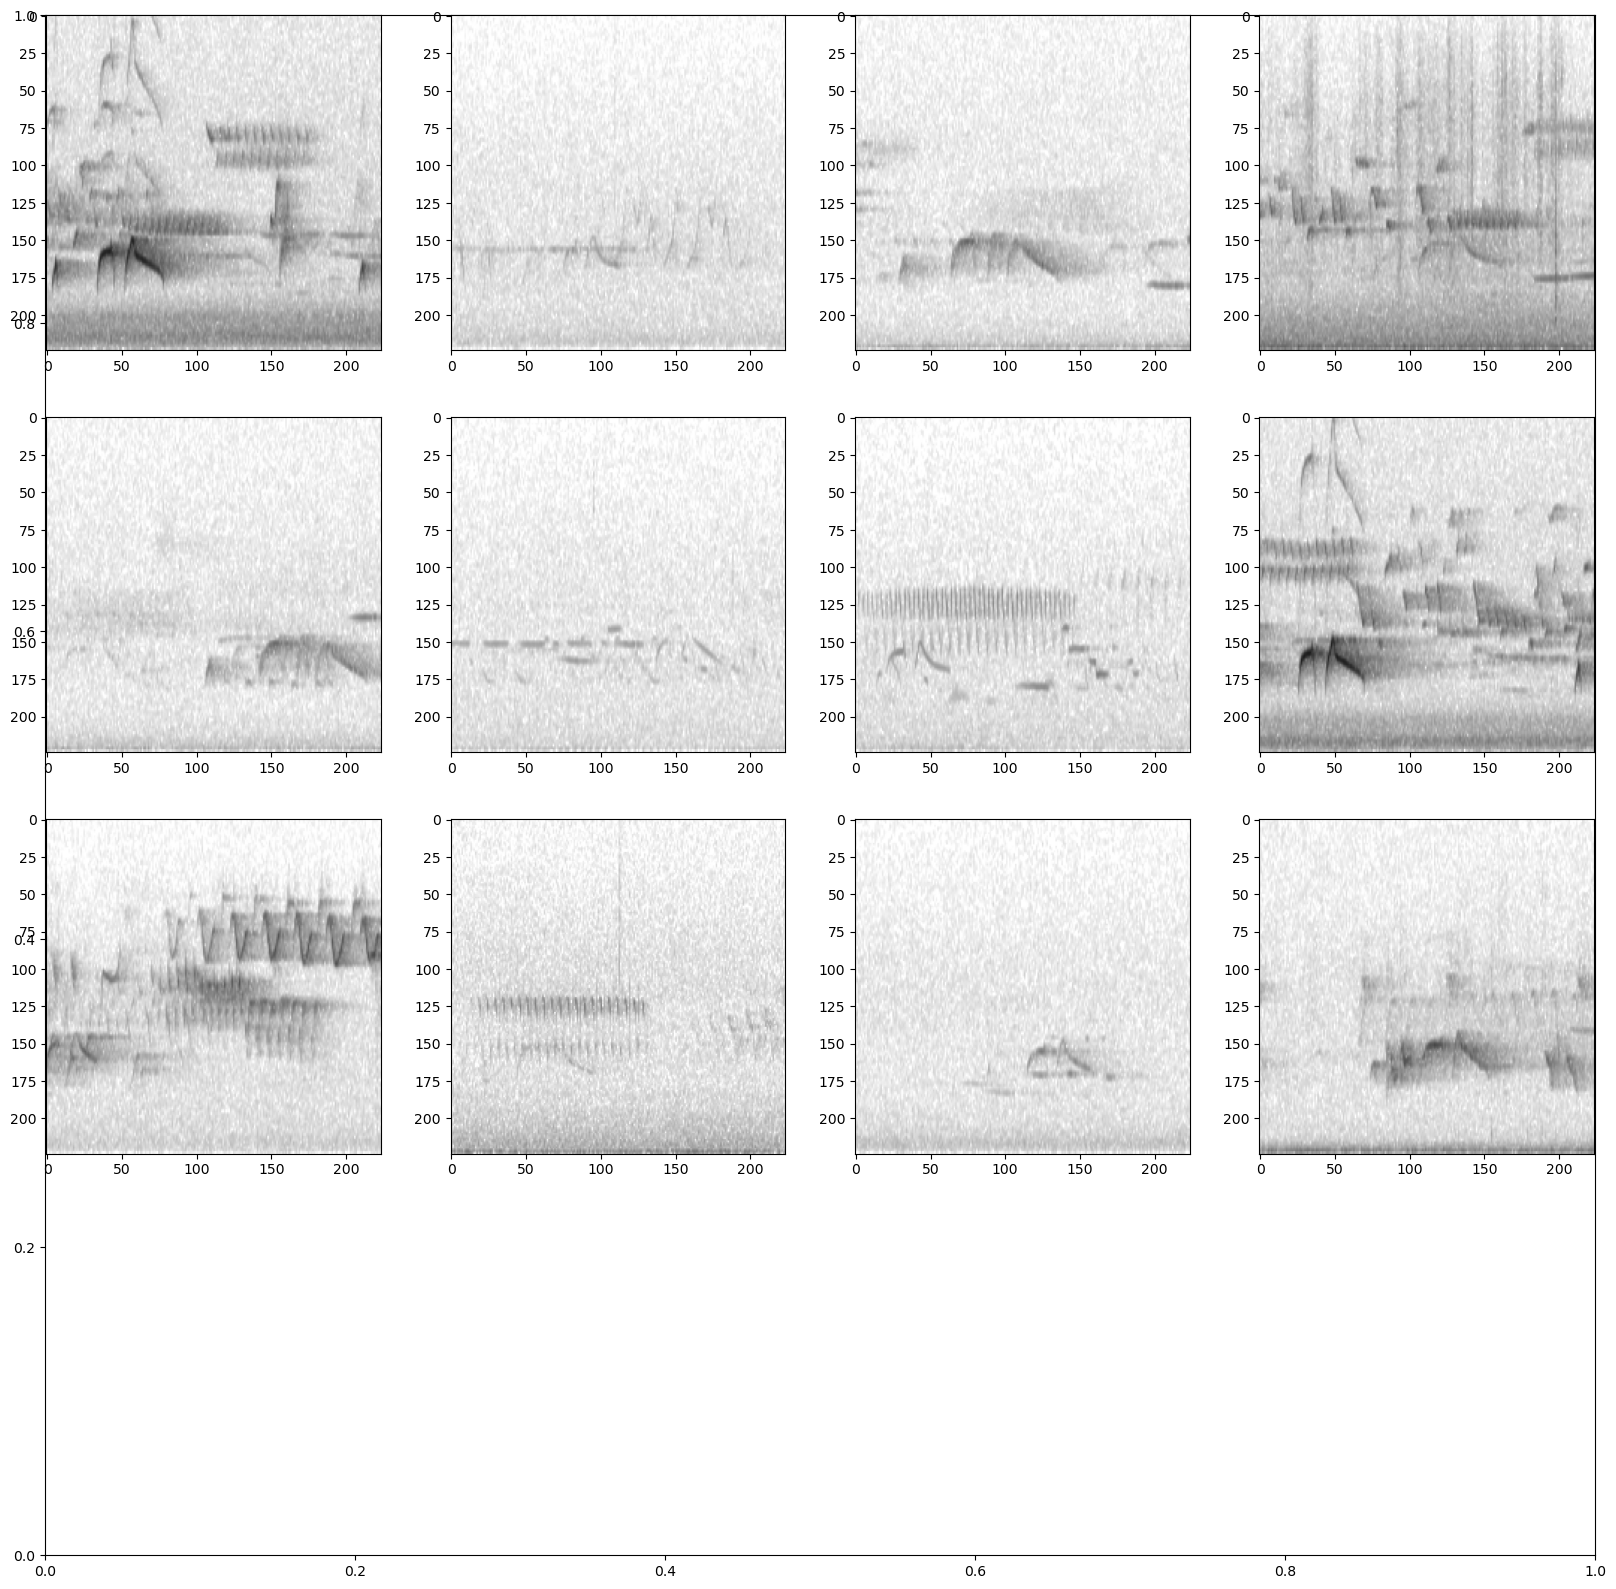

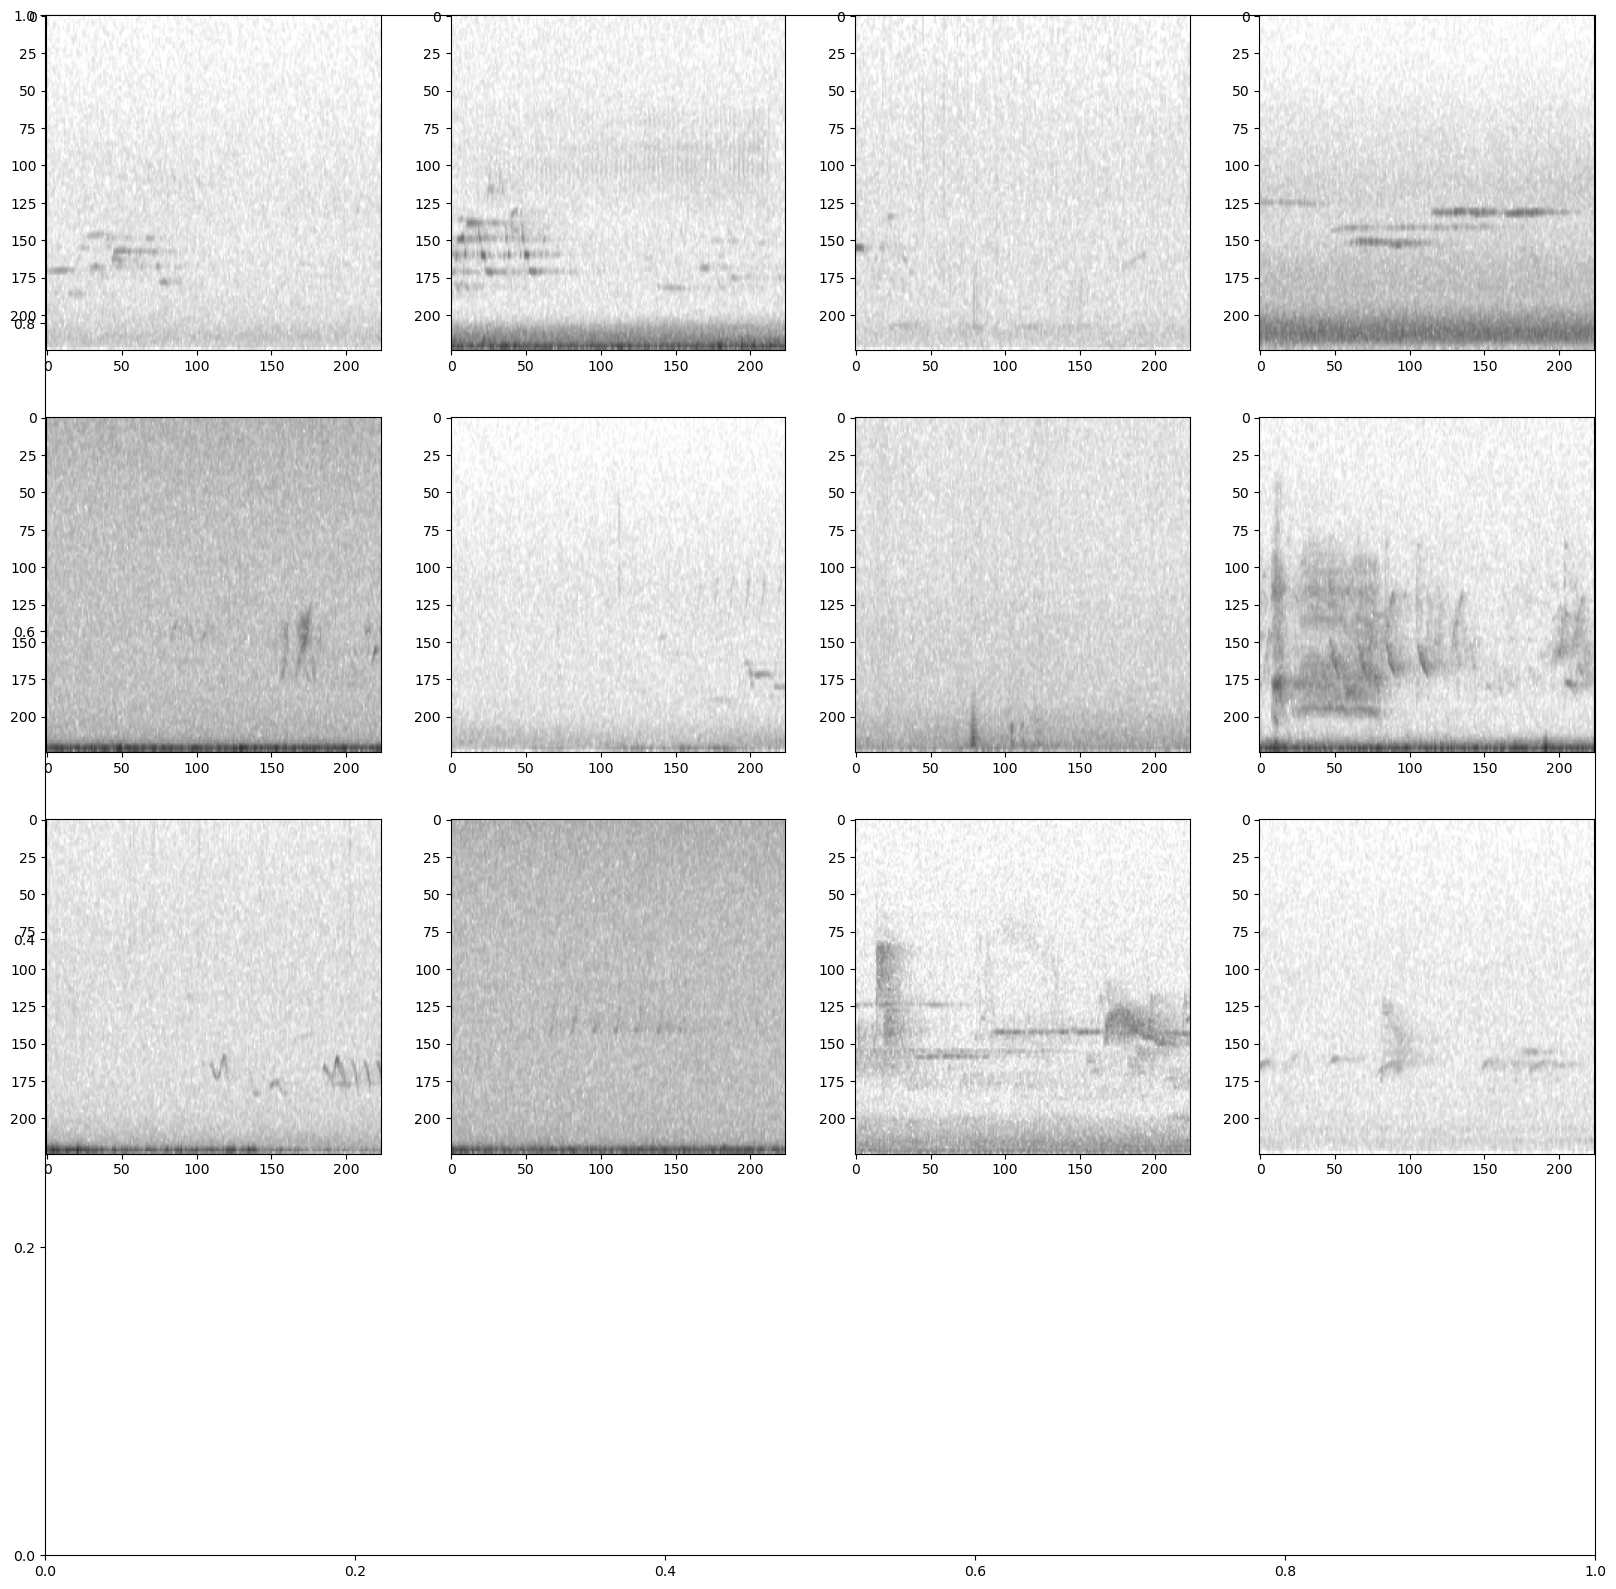

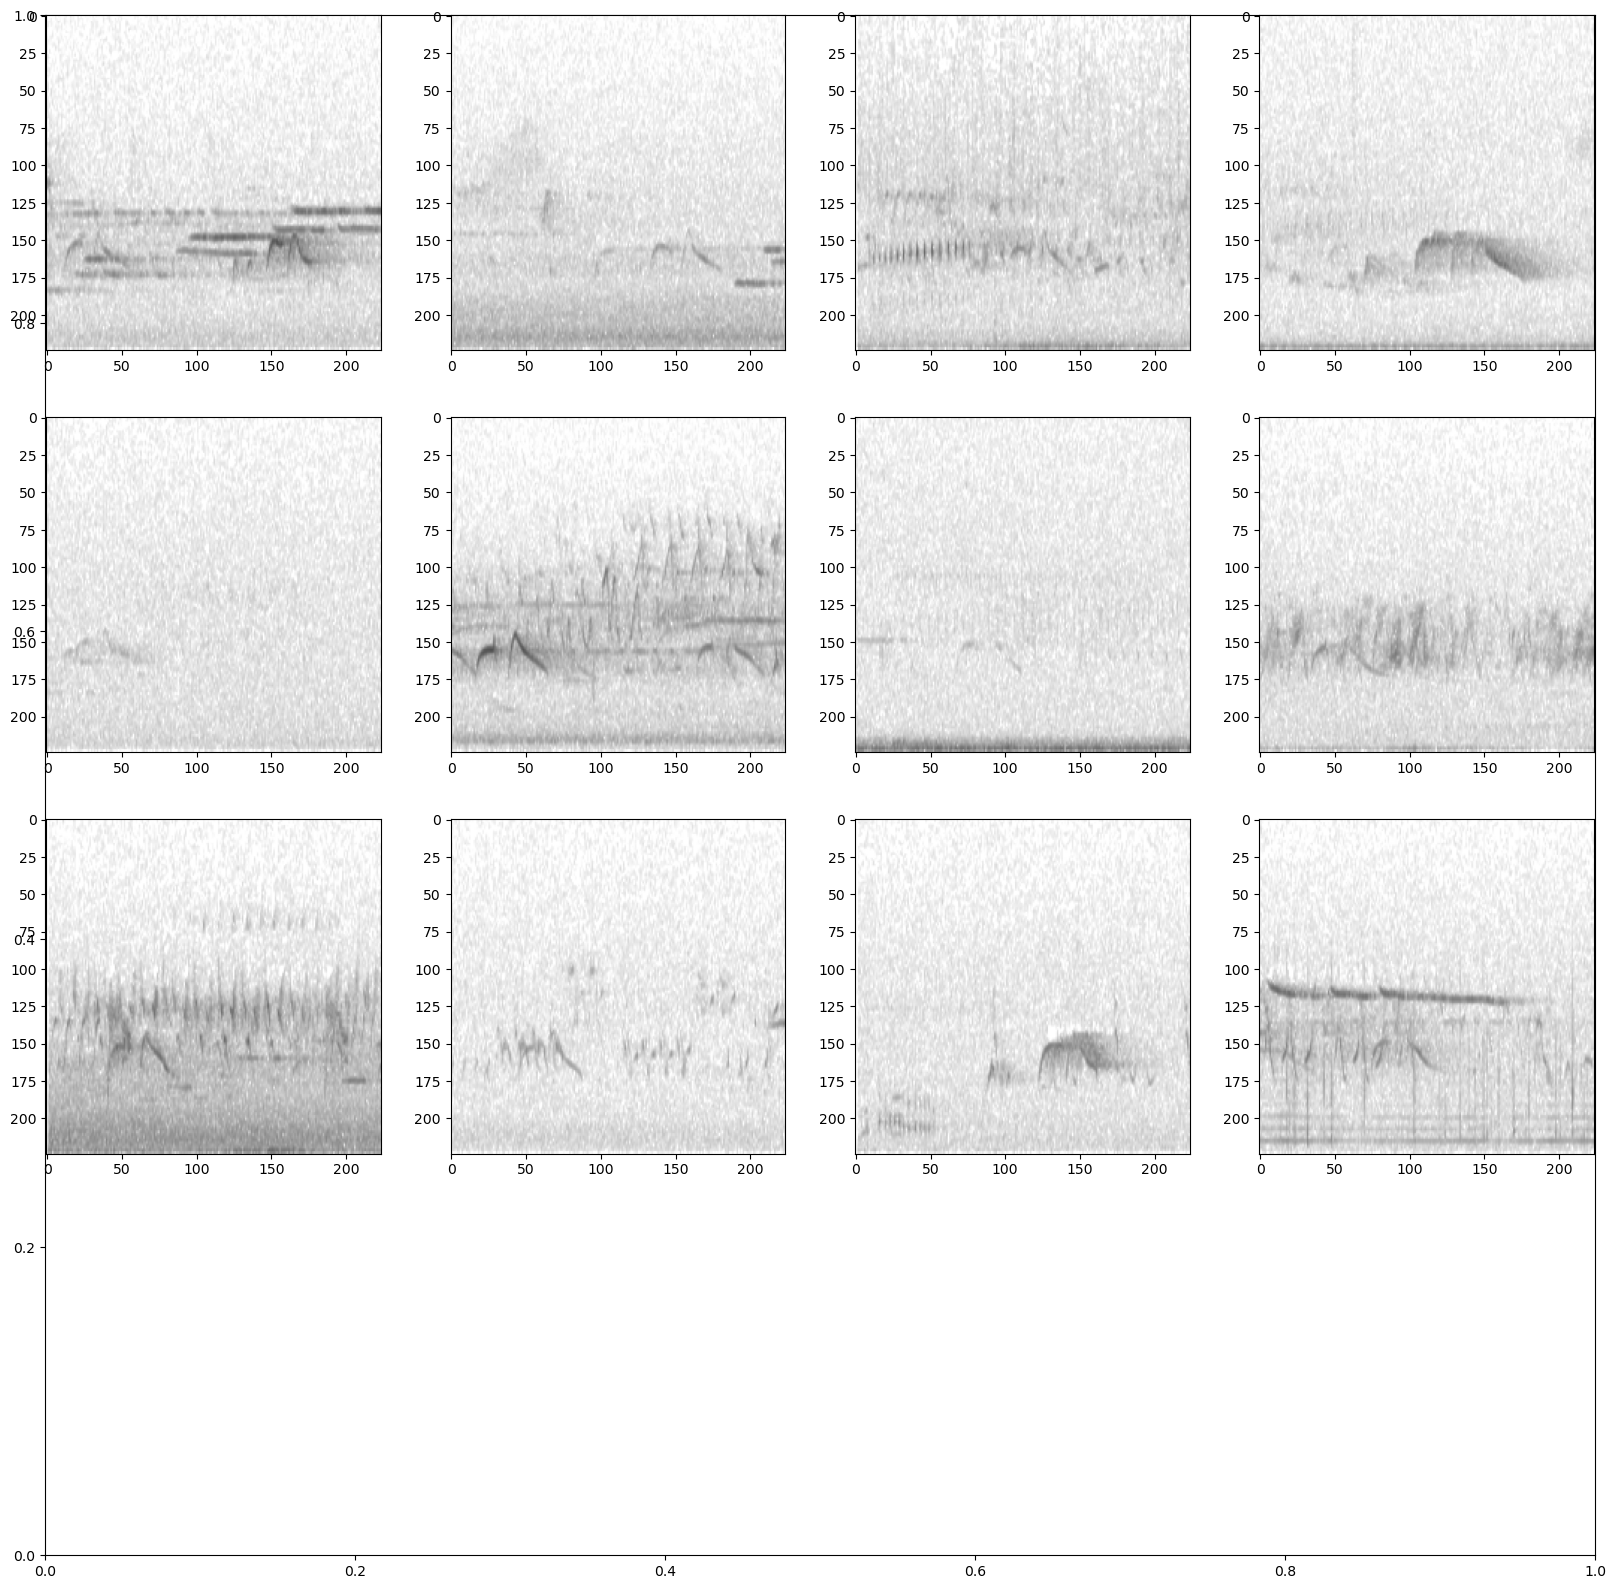

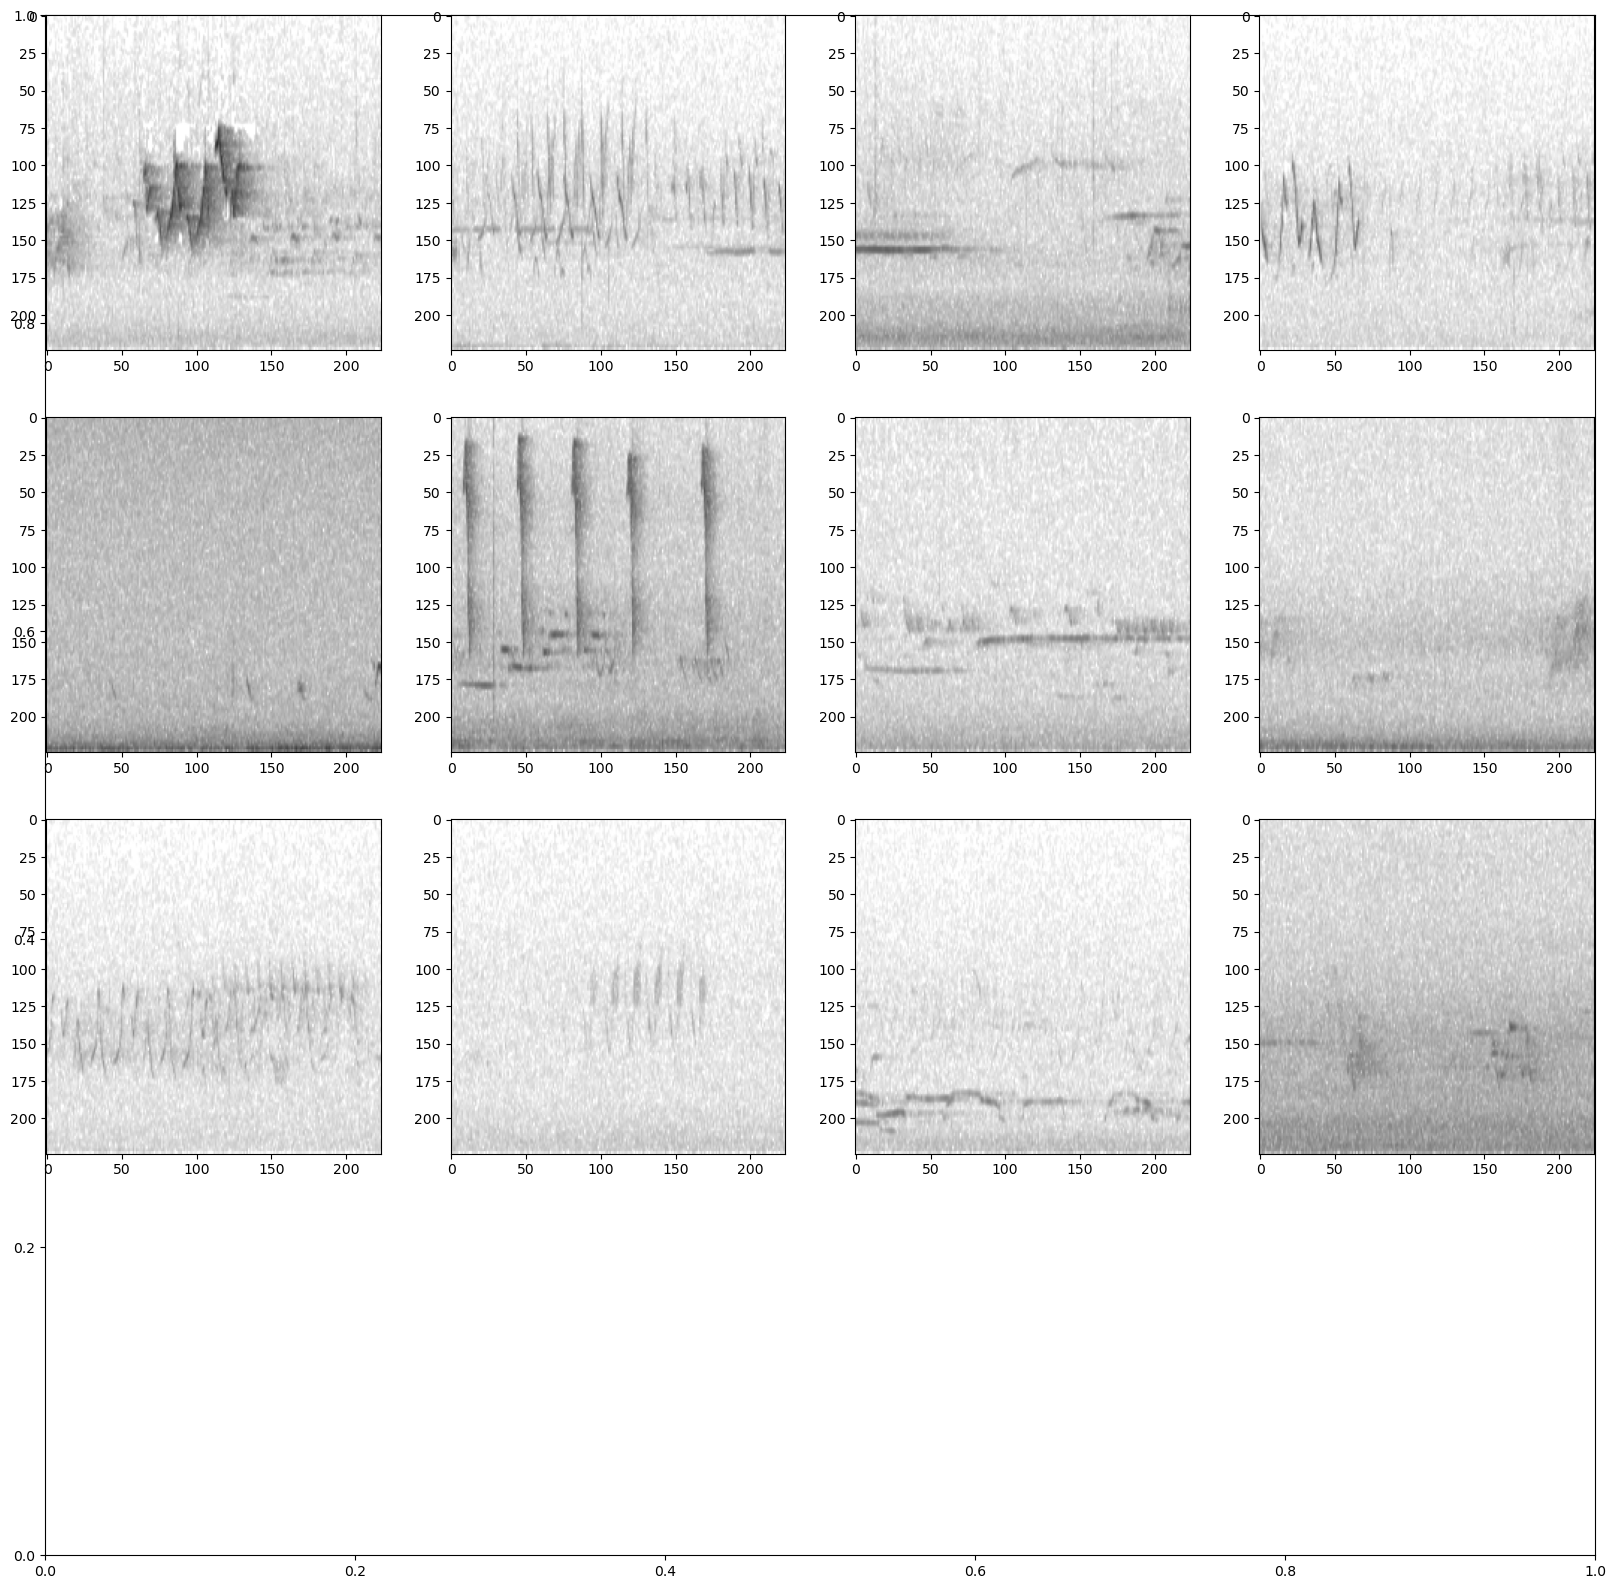

In [38]:
def inspect_input_samples(train_df, valid_df):
    present_t = train_df.loc[train_df.target_presence == 1]
    absent_t = train_df.loc[train_df.target_presence == 0]
    present_v = valid_df.loc[valid_df.target_presence == 1]
    absent_v = valid_df.loc[valid_df.target_presence == 0]

    # Generate a dataset with the samples we wish to inspect and the model's preprocessor
    for df in [present_t, absent_t, present_v, absent_v]:
        inspection_dataset = opso.AudioFileDataset(df.sample(12), model.preprocessor)
        inspection_dataset.bypass_augmentations = True

        samples = [sample.data for sample in inspection_dataset]
        _ = show_tensor_grid(samples, 4, invert=True)

inspect_input_samples(train_df, balanced_valid_df)


# Check for leakage

In [39]:
train_files = train_df.index.get_level_values("file")
valid_files = balanced_valid_df.index.get_level_values("file")
assert train_files.isin(valid_files).sum() == 0, "Train and validation sets have overlapping files"

In [40]:
model.optimizer_params['lr'] = learning_rate

In [41]:
model.network

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [42]:
class_list

['target_presence']

In [43]:
def show_sample_from_df(df=train_df, present=True,):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


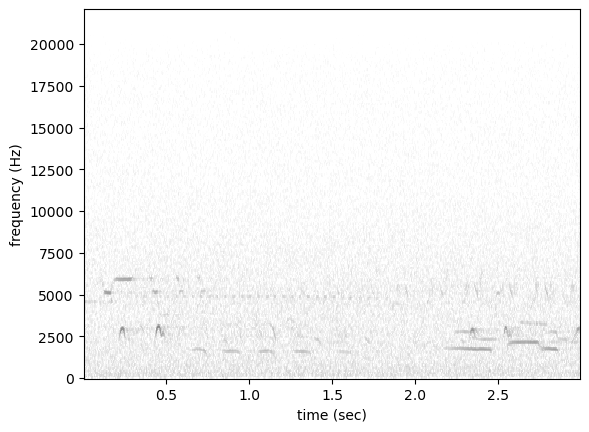

In [44]:
show_sample_from_df(df=train_df, present=True)


In [45]:
print(f'model.device is: {model.device}')

model.device is: mps


In [46]:
Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb"

PosixPath('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb')

In [47]:
%set_env WANDB_NOTEBOOK_NAME={Path(Path.cwd() / "1.27-mjg-eda-use-cleaner-data.ipynb")}

env: WANDB_NOTEBOOK_NAME=/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory_nbs/1.27-mjg-eda-use-cleaner-data.ipynb


# Weights and biases initialization

In [48]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [49]:
balanced_valid_df.value_counts()


target_presence
0.0                380
1.0                380
Name: count, dtype: int64

In [50]:
train_df.value_counts()

target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
model.train(
    train_df,
    balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 2, #4 parallelized cpu tasks for preprocessing, Reduce if training quits unexpectedly
    log_interval = 10,
    save_interval = 1,
    invalid_samples_log='./invalid_training_samples.log',
    raise_errors=True,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 0 [batch 0/121, 0.00%] 
	DistLoss: 1.324
Metrics:
Epoch: 0 [batch 10/121, 8.26%] 
	DistLoss: 1.913
Metrics:
Epoch: 0 [batch 20/121, 16.53%] 
	DistLoss: 2.391
Metrics:
Epoch: 0 [batch 30/121, 24.79%] 
	DistLoss: 2.057
Metrics:
Epoch: 0 [batch 40/121, 33.06%] 
	DistLoss: 2.111
Metrics:
Epoch: 0 [batch 50/121, 41.32%] 
	DistLoss: 2.090
Metrics:
Epoch: 0 [batch 60/121, 49.59%] 
	DistLoss: 1.965
Metrics:
Epoch: 0 [batch 70/121, 57.85%] 
	DistLoss: 1.820
Metrics:
Epoch: 0 [batch 80/121, 66.12%] 
	DistLoss: 1.706
Metrics:
Epoch: 0 [batch 90/121, 74.38%] 
	DistLoss: 1.608
Metrics:
Epoch: 0 [batch 100/121, 82.64%] 
	DistLoss: 1.530
Metrics:
Epoch: 0 [batch 110/121, 90.91%] 
	DistLoss: 1.464
Metrics:
Epoch: 0 [batch 120/121, 99.17%] 
	DistLoss: 1.419
Metrics:
Metrics:
	MAP: 0.510

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.503

Training Epoch 1


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 1 [batch 0/121, 0.00%] 
	DistLoss: 0.733
Metrics:
Epoch: 1 [batch 10/121, 8.26%] 
	DistLoss: 1.229
Metrics:
Epoch: 1 [batch 20/121, 16.53%] 
	DistLoss: 1.021
Metrics:
Epoch: 1 [batch 30/121, 24.79%] 
	DistLoss: 0.952
Metrics:
Epoch: 1 [batch 40/121, 33.06%] 
	DistLoss: 0.913
Metrics:
Epoch: 1 [batch 50/121, 41.32%] 
	DistLoss: 0.903
Metrics:
Epoch: 1 [batch 60/121, 49.59%] 
	DistLoss: 0.876
Metrics:
Epoch: 1 [batch 70/121, 57.85%] 
	DistLoss: 0.868
Metrics:
Epoch: 1 [batch 80/121, 66.12%] 
	DistLoss: 0.852
Metrics:
Epoch: 1 [batch 90/121, 74.38%] 
	DistLoss: 0.842
Metrics:
Epoch: 1 [batch 100/121, 82.64%] 
	DistLoss: 0.827
Metrics:
Epoch: 1 [batch 110/121, 90.91%] 
	DistLoss: 0.815
Metrics:
Epoch: 1 [batch 120/121, 99.17%] 
	DistLoss: 0.805
Metrics:
Metrics:
	MAP: 0.583

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.611

Training Epoch 2


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 2 [batch 0/121, 0.00%] 
	DistLoss: 0.624
Metrics:
Epoch: 2 [batch 10/121, 8.26%] 
	DistLoss: 0.662
Metrics:
Epoch: 2 [batch 20/121, 16.53%] 
	DistLoss: 0.719
Metrics:
Epoch: 2 [batch 30/121, 24.79%] 
	DistLoss: 0.707
Metrics:
Epoch: 2 [batch 40/121, 33.06%] 
	DistLoss: 0.698
Metrics:
Epoch: 2 [batch 50/121, 41.32%] 
	DistLoss: 0.702
Metrics:
Epoch: 2 [batch 60/121, 49.59%] 
	DistLoss: 0.700
Metrics:
Epoch: 2 [batch 70/121, 57.85%] 
	DistLoss: 0.700
Metrics:
Epoch: 2 [batch 80/121, 66.12%] 
	DistLoss: 0.694
Metrics:
Epoch: 2 [batch 90/121, 74.38%] 
	DistLoss: 0.701
Metrics:
Epoch: 2 [batch 100/121, 82.64%] 
	DistLoss: 0.700
Metrics:
Epoch: 2 [batch 110/121, 90.91%] 
	DistLoss: 0.697
Metrics:
Epoch: 2 [batch 120/121, 99.17%] 
	DistLoss: 0.691
Metrics:
Metrics:
	MAP: 0.674

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.658

Training Epoch 3


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 3 [batch 0/121, 0.00%] 
	DistLoss: 1.009
Metrics:
Epoch: 3 [batch 10/121, 8.26%] 
	DistLoss: 0.958
Metrics:
Epoch: 3 [batch 20/121, 16.53%] 
	DistLoss: 0.822
Metrics:
Epoch: 3 [batch 30/121, 24.79%] 
	DistLoss: 0.773
Metrics:
Epoch: 3 [batch 40/121, 33.06%] 
	DistLoss: 0.742
Metrics:
Epoch: 3 [batch 50/121, 41.32%] 
	DistLoss: 0.733
Metrics:
Epoch: 3 [batch 60/121, 49.59%] 
	DistLoss: 0.717
Metrics:
Epoch: 3 [batch 70/121, 57.85%] 
	DistLoss: 0.711
Metrics:
Epoch: 3 [batch 80/121, 66.12%] 
	DistLoss: 0.699
Metrics:
Epoch: 3 [batch 90/121, 74.38%] 
	DistLoss: 0.684
Metrics:
Epoch: 3 [batch 100/121, 82.64%] 
	DistLoss: 0.675
Metrics:
Epoch: 3 [batch 110/121, 90.91%] 
	DistLoss: 0.666
Metrics:
Epoch: 3 [batch 120/121, 99.17%] 
	DistLoss: 0.674
Metrics:
Metrics:
	MAP: 0.759

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.853

Training Epoch 4


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 4 [batch 0/121, 0.00%] 
	DistLoss: 0.713
Metrics:
Epoch: 4 [batch 10/121, 8.26%] 
	DistLoss: 0.726
Metrics:
Epoch: 4 [batch 20/121, 16.53%] 
	DistLoss: 0.651
Metrics:
Epoch: 4 [batch 30/121, 24.79%] 
	DistLoss: 0.654
Metrics:
Epoch: 4 [batch 40/121, 33.06%] 
	DistLoss: 0.627
Metrics:
Epoch: 4 [batch 50/121, 41.32%] 
	DistLoss: 0.627
Metrics:
Epoch: 4 [batch 60/121, 49.59%] 
	DistLoss: 0.617
Metrics:
Epoch: 4 [batch 70/121, 57.85%] 
	DistLoss: 0.605
Metrics:
Epoch: 4 [batch 80/121, 66.12%] 
	DistLoss: 0.591
Metrics:
Epoch: 4 [batch 90/121, 74.38%] 
	DistLoss: 0.581
Metrics:
Epoch: 4 [batch 100/121, 82.64%] 
	DistLoss: 0.575
Metrics:
Epoch: 4 [batch 110/121, 90.91%] 
	DistLoss: 0.571
Metrics:
Epoch: 4 [batch 120/121, 99.17%] 
	DistLoss: 0.566
Metrics:
Metrics:
	MAP: 0.819

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.950

Training Epoch 5


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 5 [batch 0/121, 0.00%] 
	DistLoss: 0.391
Metrics:
Epoch: 5 [batch 10/121, 8.26%] 
	DistLoss: 0.487
Metrics:
Epoch: 5 [batch 20/121, 16.53%] 
	DistLoss: 0.483
Metrics:
Epoch: 5 [batch 30/121, 24.79%] 
	DistLoss: 0.491
Metrics:
Epoch: 5 [batch 40/121, 33.06%] 
	DistLoss: 0.487
Metrics:
Epoch: 5 [batch 50/121, 41.32%] 
	DistLoss: 0.483
Metrics:
Epoch: 5 [batch 60/121, 49.59%] 
	DistLoss: 0.481
Metrics:
Epoch: 5 [batch 70/121, 57.85%] 
	DistLoss: 0.484
Metrics:
Epoch: 5 [batch 80/121, 66.12%] 
	DistLoss: 0.493
Metrics:
Epoch: 5 [batch 90/121, 74.38%] 
	DistLoss: 0.486
Metrics:
Epoch: 5 [batch 100/121, 82.64%] 
	DistLoss: 0.479
Metrics:
Epoch: 5 [batch 110/121, 90.91%] 
	DistLoss: 0.469
Metrics:
Epoch: 5 [batch 120/121, 99.17%] 
	DistLoss: 0.480
Metrics:
Metrics:
	MAP: 0.875

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.956

Training Epoch 6


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 6 [batch 0/121, 0.00%] 
	DistLoss: 0.360
Metrics:
Epoch: 6 [batch 10/121, 8.26%] 
	DistLoss: 0.466
Metrics:
Epoch: 6 [batch 20/121, 16.53%] 
	DistLoss: 0.511
Metrics:
Epoch: 6 [batch 30/121, 24.79%] 
	DistLoss: 0.520
Metrics:
Epoch: 6 [batch 40/121, 33.06%] 
	DistLoss: 0.503
Metrics:
Epoch: 6 [batch 50/121, 41.32%] 
	DistLoss: 0.496
Metrics:
Epoch: 6 [batch 60/121, 49.59%] 
	DistLoss: 0.487
Metrics:
Epoch: 6 [batch 70/121, 57.85%] 
	DistLoss: 0.480
Metrics:
Epoch: 6 [batch 80/121, 66.12%] 
	DistLoss: 0.476
Metrics:
Epoch: 6 [batch 90/121, 74.38%] 
	DistLoss: 0.483
Metrics:
Epoch: 6 [batch 100/121, 82.64%] 
	DistLoss: 0.483
Metrics:
Epoch: 6 [batch 110/121, 90.91%] 
	DistLoss: 0.479
Metrics:
Epoch: 6 [batch 120/121, 99.17%] 
	DistLoss: 0.476
Metrics:
Metrics:
	MAP: 0.876

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.974

Training Epoch 7


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 7 [batch 0/121, 0.00%] 
	DistLoss: 0.262
Metrics:
Epoch: 7 [batch 10/121, 8.26%] 
	DistLoss: 0.590
Metrics:
Epoch: 7 [batch 20/121, 16.53%] 
	DistLoss: 0.503
Metrics:
Epoch: 7 [batch 30/121, 24.79%] 
	DistLoss: 0.567
Metrics:
Epoch: 7 [batch 40/121, 33.06%] 
	DistLoss: 0.542
Metrics:
Epoch: 7 [batch 50/121, 41.32%] 
	DistLoss: 0.516
Metrics:
Epoch: 7 [batch 60/121, 49.59%] 
	DistLoss: 0.497
Metrics:
Epoch: 7 [batch 70/121, 57.85%] 
	DistLoss: 0.492
Metrics:
Epoch: 7 [batch 80/121, 66.12%] 
	DistLoss: 0.478
Metrics:
Epoch: 7 [batch 90/121, 74.38%] 
	DistLoss: 0.474
Metrics:
Epoch: 7 [batch 100/121, 82.64%] 
	DistLoss: 0.468
Metrics:
Epoch: 7 [batch 110/121, 90.91%] 
	DistLoss: 0.460
Metrics:
Epoch: 7 [batch 120/121, 99.17%] 
	DistLoss: 0.457
Metrics:
Metrics:
	MAP: 0.896

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.947

Training Epoch 8


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 8 [batch 0/121, 0.00%] 
	DistLoss: 0.345
Metrics:
Epoch: 8 [batch 10/121, 8.26%] 
	DistLoss: 0.400
Metrics:
Epoch: 8 [batch 20/121, 16.53%] 
	DistLoss: 0.431
Metrics:
Epoch: 8 [batch 30/121, 24.79%] 
	DistLoss: 0.434
Metrics:
Epoch: 8 [batch 40/121, 33.06%] 
	DistLoss: 0.444
Metrics:
Epoch: 8 [batch 50/121, 41.32%] 
	DistLoss: 0.445
Metrics:
Epoch: 8 [batch 60/121, 49.59%] 
	DistLoss: 0.439
Metrics:
Epoch: 8 [batch 70/121, 57.85%] 
	DistLoss: 0.437
Metrics:
Epoch: 8 [batch 80/121, 66.12%] 
	DistLoss: 0.436
Metrics:
Epoch: 8 [batch 90/121, 74.38%] 
	DistLoss: 0.424
Metrics:
Epoch: 8 [batch 100/121, 82.64%] 
	DistLoss: 0.421
Metrics:
Epoch: 8 [batch 110/121, 90.91%] 
	DistLoss: 0.413
Metrics:
Epoch: 8 [batch 120/121, 99.17%] 
	DistLoss: 0.407
Metrics:
Metrics:
	MAP: 0.906

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.982

Training Epoch 9


  0%|          | 0/121 [00:00<?, ?it/s]

Epoch: 9 [batch 0/121, 0.00%] 
	DistLoss: 0.382
Metrics:
Epoch: 9 [batch 10/121, 8.26%] 
	DistLoss: 0.414
Metrics:
Epoch: 9 [batch 20/121, 16.53%] 
	DistLoss: 0.420
Metrics:
Epoch: 9 [batch 30/121, 24.79%] 
	DistLoss: 0.408
Metrics:
Epoch: 9 [batch 40/121, 33.06%] 
	DistLoss: 0.395
Metrics:
Epoch: 9 [batch 50/121, 41.32%] 
	DistLoss: 0.385
Metrics:
Epoch: 9 [batch 60/121, 49.59%] 
	DistLoss: 0.389
Metrics:
Epoch: 9 [batch 70/121, 57.85%] 
	DistLoss: 0.388
Metrics:
Epoch: 9 [batch 80/121, 66.12%] 
	DistLoss: 0.385
Metrics:
Epoch: 9 [batch 90/121, 74.38%] 
	DistLoss: 0.389
Metrics:
Epoch: 9 [batch 100/121, 82.64%] 
	DistLoss: 0.392
Metrics:
Epoch: 9 [batch 110/121, 90.91%] 
	DistLoss: 0.392
Metrics:
Epoch: 9 [batch 120/121, 99.17%] 
	DistLoss: 0.388
Metrics:
Metrics:
	MAP: 0.921

Validation.


  0%|          | 0/12 [00:00<?, ?it/s]

Metrics:
	MAP: 0.982

Best Model Appears at Epoch 9 with Validation score 0.982.


In [71]:
# Load the checkpoint from the best epoch
model = opso.load_model("best.model")

# Show metrics per epoch

In [72]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.49386890709623665,
   'avg_precision': 0.5031891868643075,
   'precision': 0.4921259842519685,
   'recall': 0.6596306068601583,
   'f1': 0.5636978579481398,
   'support': 379},
  'precision': 0.4890908805721994,
  'recall': 0.4903416192195528,
  'f1': 0.47519282754776243,
  'jaccard': 0.31607516816610276,
  'hamming_loss': 0.5098814229249012,
  'map': 0.5031891868643075,
  'au_roc': 0.49386890709623665},
 1: {'target_presence': {'au_roc': 0.6534023052353839,
   'avg_precision': 0.6105919394701887,
   'precision': 0.5006747638326585,
   'recall': 0.978891820580475,
   'f1': 0.6624999999999999,
   'support': 379},
  'precision': 0.528115159694107,
  'recall': 0.5026038050270796,
  'f1': 0.35637562814070345,
  'jaccard': 0.26055014934001347,
  'hamming_loss': 0.4980237154150198,
  'map': 0.6105919394701887,
  'au_roc': 0.6534023052353839},
 2: {'target_presence': {'au_roc': 0.7053187057353145,
   'avg_precision': 0.6578314665340632,
   'precision': 0.5

In [55]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.5346484755646698,
   'avg_precision': 0.5100025025541695,
   'precision': 0.53125,
   'recall': 0.6943176052765094,
   'f1': 0.6019353419837256,
   'support': 3942},
  'precision': 0.5277647552309515,
  'recall': 0.5245566118821767,
  'f1': 0.5125674160524109,
  'jaccard': 0.3494701351504125,
  'hamming_loss': 0.47104749512036437,
  'map': 0.5100025025541695,
  'au_roc': 0.5346484755646698},
 1: {'target_presence': {'au_roc': 0.6029719199837668,
   'avg_precision': 0.5828112339965127,
   'precision': 0.5552668052668053,
   'recall': 0.813039066463724,
   'f1': 0.6598723491867408,
   'support': 3942},
  'precision': 0.5850040246929948,
  'recall': 0.5636127739478652,
  'f1': 0.5378569666725783,
  'jaccard': 0.37744757259179595,
  'hamming_loss': 0.42992843201040987,
  'map': 0.5828112339965127,
  'au_roc': 0.6029719199837668},
 2: {'target_presence': {'au_roc': 0.6933505371027102,
   'avg_precision': 0.6738731877973594,
   'precision': 0.599385616190

# Plot a confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

In [56]:
scores_df = model.predict(balanced_valid_df, activation_layer='sigmoid')

  0%|          | 0/760 [00:00<?, ?it/s]

In [57]:
def get_binary_predictions(target_df, model_predictions_df, threshold=0.5):
    '''
    Calculate the binary predictions needed for confusion matrix and other metrics. 
    target_df: DataFrame with labels in the target_presence column
    model_predictions_df: DataFrame with model predictions in target_presence column
    '''
    targets = target_df.target_presence.values
    scores = model_predictions_df.target_presence.values
    binary_preds = (scores > threshold).astype(float)
    return binary_preds, targets, scores


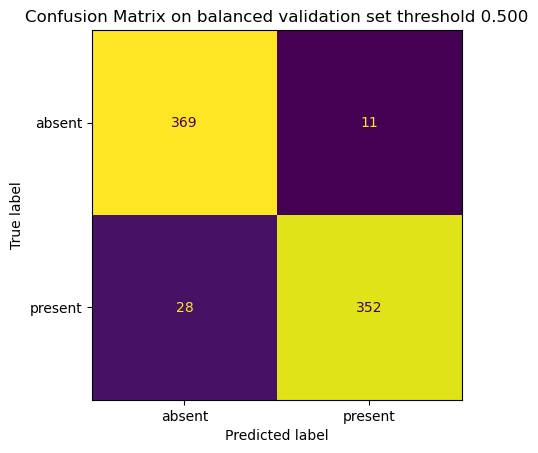

In [58]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(balanced_valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion Matrix on balanced validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Look at the metrics across thresholds
for the balanced validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


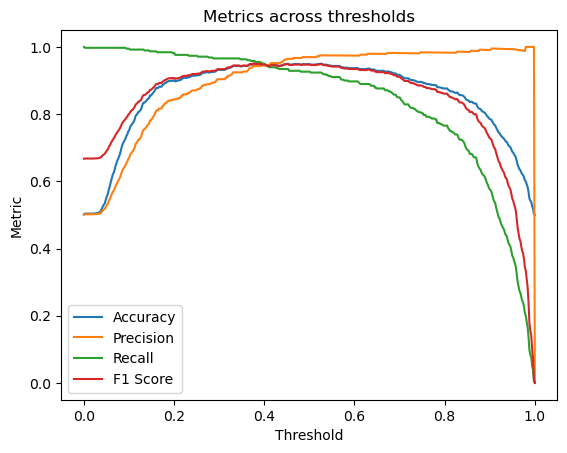

In [59]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

In [60]:
cm

array([[369,  11],
       [ 28, 352]])

In [61]:
# log confusion matrix to wandb as a table
wandb.log({"validation.confusion_matrix": cm})


In [62]:
def log_single_metric(metric, name):
    data = [[x, y] for (x, y) in zip(thresholds, metric)]
    table = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            f"custom {name}": wandb.plot.line(
                table, "x", "y", title=f"Custom {name} vs threshold plot"
            )
        }
    )
log_single_metric(accuracies, "accuracy")
log_single_metric(precisions, "precision")
log_single_metric(recalls, "recall")
log_single_metric(f1s, "f1")


# Make predictions and plot confusion matrix on the full validation set
During training we only looked at a subset of the validation set values. 

In [63]:
scores_df = model.predict(valid_df, activation_layer='sigmoid')


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10334 [00:00<?, ?it/s]

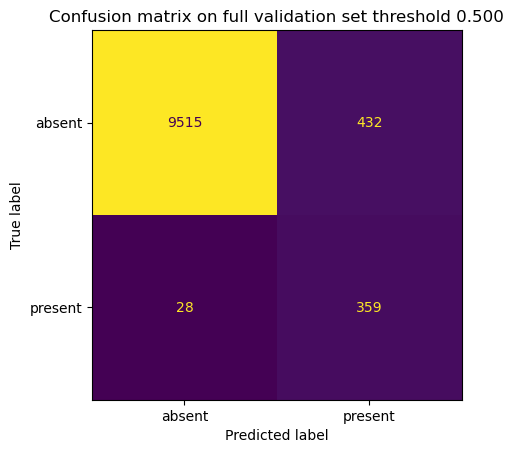

In [64]:
threshold = 0.5
# Calculate the confusion matrix
binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

# Plot the confusion matrix
fig, ax = plt.subplots()
ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.3f}")
cm_display.plot(ax=ax, colorbar=False)

# Interactive confusion matrix


In [65]:
import ipywidgets as widgets
def show_cm(threshold):
    # Calculate the confusion matrix
    binary_preds, targets, scores = get_binary_predictions(valid_df, scores_df, threshold=threshold)
    cm = sklearn.metrics.confusion_matrix(targets, binary_preds)
    cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=["absent", "present"])

    # Plot the confusion matrix
    fig, ax = plt.subplots()
    ax.set_title(f"Confusion matrix on full validation set threshold {threshold:.4f}")
    cm_display.plot(ax=ax, colorbar=False)

from ipywidgets import interact
interact(show_cm, threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.0001, value=0.5))
# show_cm(0.5)

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.0001), Output()), _dom_c…

<function __main__.show_cm(threshold)>

# Look at the metrics across thresholds
for the full validation set

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


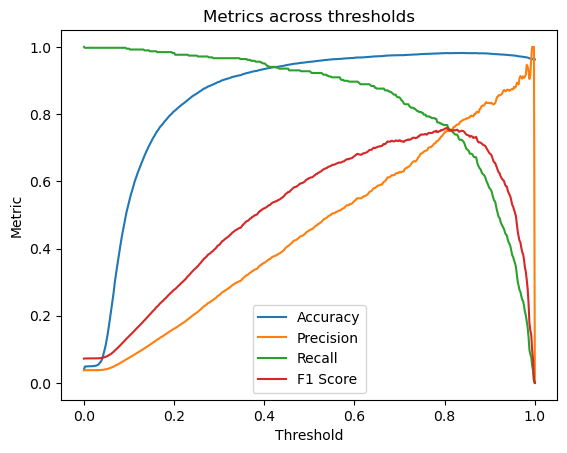

In [66]:
plot_data, legend = plot_metrics_across_thresholds(pd.DataFrame({"label":targets, "present_pred":scores}))
thresholds, accuracies, precisions, recalls, f1s = zip(*list(plot_data))

log_single_metric(accuracies, "accuracy_full_set")
log_single_metric(precisions, "precision_full_set")
log_single_metric(recalls, "recall_full_set")
log_single_metric(f1s, "f1_full_set")

# Result: 
Training on 1700 from each class produces a model with high precision and recall. 

# Too good to be true?
Load the results into notebook 1.21 for sanity check. There you can load a pretrained model, make predictions on the validation set, and look at predictions in order of highest error for each class. 

# Save the best model to disk


In [67]:
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"{wandb.run.name}efficientnet_1971_1700_3942.model")

In [68]:
train_df.value_counts()


target_presence
0.0                3942
1.0                3743
Name: count, dtype: int64

In [69]:
wandb.finish()

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore
